In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
if False:
  %cd /content/drive/MyDrive/ml-project-2-roadmen-bruv/
if False:
  %cd "/content/drive/MyDrive/ML_google_colab/Project 2/ml-project-2-roadmen-bruv"
if True:
  %cd "/content/drive/MyDrive/EPFL/MachineLearningMA3/Project 2/ml-project-2-roadmen-bruv"

/content/drive/MyDrive/EPFL/MachineLearningMA3/Project 2/ml-project-2-roadmen-bruv


## Libraries

In [3]:
from IPython.display import clear_output
!pip install -U git+https://github.com/jlcsilva/segmentation_models.pytorch
!pip install -U albumentations
clear_output()

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import segmentation_models_pytorch as smp
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os, sys
import torch
from PIL import Image
import albumentations as albu
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from PIL import Image
import pandas as pd
from data.mask_to_submission import masks_to_submission
from utils.data_augmentation import load_img_training, split_keys, store_images, resize_augment_store_dataset


# 0) Data aug

In [5]:
 create_aug_data = False
 if create_aug_data:
  # Create folders for data augmentation
  %mkdir data/data_train_augmented
  %mkdir data/data_train_augmented/images/
  %mkdir data/data_train_augmented/masks/
  %mkdir data/data_train_augmented/raw/
  %mkdir data/data_train_augmented/raw/images/
  %mkdir data/data_train_augmented/raw/masks/
  %mkdir data/data_validation
  %mkdir data/data_validation/images/
  %mkdir data/data_validation/masks/
  %mkdir data/data_validation/raw/
  %mkdir data/data_validation/raw/images/
  %mkdir data/data_validation/raw/masks/

  # Load images and masks from dataset
  PATH_IMG_TRAIN = "./data/training/images/"
  PATH_MASK_TRAIN = "./data/training/groundtruth/"
  img_train, mask_train = load_img_training(PATH_IMG_TRAIN, PATH_MASK_TRAIN)
  key_list = list(img_train.keys())
  key_list.sort()

  # Split the images for training/validation (+ store)
  training_ratio = 0.8
  seed = 1
  train_keys, val_keys = split_keys(np.array(key_list), training_ratio=training_ratio, seed=seed)

  PATH_TR_IMG_AUG_RAW = "./data/data_train_augmented/raw/images/"
  PATH_TR_MASK_AUG_RAW = "./data/data_train_augmented/raw/masks/"
  PATH_VAL_IMG_RAW = "./data/data_validation/raw/images/"
  PATH_VAL_MASK_RAW = "./data/data_validation/raw/masks/"

  store_images(img_train, train_keys, PATH_TR_IMG_AUG_RAW)
  store_images(mask_train, train_keys, PATH_TR_MASK_AUG_RAW)
  store_images(img_train, val_keys, PATH_VAL_IMG_RAW)
  store_images(mask_train, val_keys, PATH_VAL_MASK_RAW)

  MASK_THRESHOLD = 120
  SIZE_X = 416 #divisible by 32
  SIZE_Y = 416 #divisible by 32
  PATH_TR_IMG_AUG = "./data/data_train_augmented/images/"
  PATH_TR_MASK_AUG = "./data/data_train_augmented/masks/"
  PATH_VAL_IMG = "./data/data_validation/images/"
  PATH_VAL_MASK = "./data/data_validation/masks/"

  # Load validation images and resize
  img_val_raw, mask_val_raw = load_img_training(PATH_VAL_IMG_RAW, PATH_VAL_MASK_RAW)
  keys_val = list(img_val_raw.keys())
  resize_augment_store_dataset(img_val_raw, mask_val_raw, keys_val, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_VAL_IMG, PATH_VAL_MASK, augment=False)

  # Load training images, resize and augment using geometric transformation (+ store)
  img_tr_raw, mask_tr_raw = load_img_training(PATH_TR_IMG_AUG_RAW, PATH_TR_MASK_AUG_RAW)
  keys_tr = list(img_tr_raw.keys())
  resize_augment_store_dataset(img_tr_raw, mask_tr_raw, keys_tr, SIZE_Y, SIZE_X, MASK_THRESHOLD, PATH_TR_IMG_AUG, PATH_TR_MASK_AUG, augment=True)

# I) Model training

## Model choice

In [37]:
MODELS = ["FPN","Unet","DeepLabV3"] # Available : "Unet","DeepLabV3","FPN"
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'
NB_EPOCHS = 20
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation

## Dataset class definition

In [38]:
class Dataset(BaseDataset):
    CLASSES = ['road', 'unlabelled']

    def __init__(self, images_dir, masks_dir=None, classes=None, augmentation=None, preprocessing=None):
        if masks_dir == None:
          self.ids = range(1, 51)
          self.images_fps = [os.path.join(images_dir, f'test_{idx}/',f'test_{idx}.png') for idx in self.ids]
        else:
          self.ids = os.listdir(images_dir)
          self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids] if masks_dir is not None else None

        # convert str names to class values on masks
        if classes is not None:
            self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (416, 416))
        # initialize mask as None
        mask = None

        if self.masks_fps == None:
          print(self.images_fps[i])
          if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']
          if self.preprocessing:
              sample = self.preprocessing(image=image)
              image = sample['image']
          return self.images_fps[i], image

        else:
          mask = cv2.imread(self.masks_fps[i], 0)
          mask = cv2.resize(mask, (416, 416))
          masks = [(mask == v) for v in self.class_values]
          mask = np.stack(masks, axis=-1).astype('float')
          if self.augmentation:
              sample = self.augmentation(image=image, mask=mask)
              image, mask = sample['image'], sample['mask']
          if self.preprocessing:
                sample = self.preprocessing(image=image, mask=mask)
                image, mask = sample['image'], sample['mask']
          return image, mask

    def __len__(self):
        return len(self.ids)

## Model definitions

In [39]:
CLASSES = ['road']
DEVICE = 'cuda'

def deep_lab_v3_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
    model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
    )
    return model

def unet_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
  model = smp.Unet(
  encoder_name=ENCODER,
  encoder_weights=ENCODER_WEIGHTS,
  classes=len(CLASSES),
  activation=ACTIVATION,
  )
  return model

def FPN_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE):
  model = smp.FPN(
  encoder_name=ENCODER,
  encoder_weights=ENCODER_WEIGHTS,
  classes=len(CLASSES),
  activation=ACTIVATION,
  )
  return model


# Dictionary mapping the string key to a function
model_functions = {
    'DeepLabV3': deep_lab_v3_function,
    'Unet': unet_function,
    'FPN': FPN_function
}

models = [[model_functions[model_name](ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE),model_name] for model_name in MODELS]

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

## Data importation, preprocessing and evaluation metrics def

In [40]:
def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform

    Args:
        preprocessing_fn (callbale): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose

    """

    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

In [41]:
train_dataset = Dataset(
    "./data/data_train_augmented/images",
    "./data/data_train_augmented/masks",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=['road'])


valid_dataset = Dataset(
    "./data/data_validation/images",
    "./data/data_validation/masks",
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=["road"],
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
]

## Training

In [43]:
# train model for NB_EPOCHS


for model,model_name in models:
  print(model_name)
  optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

  train_epoch = smp.utils.train.TrainEpoch(
      model,
      loss=loss,
      metrics=metrics,
      optimizer=optimizer,
      device=DEVICE,
      verbose=True,
  )

  valid_epoch = smp.utils.train.ValidEpoch(
      model,
      loss=loss,
      metrics=metrics,
      device=DEVICE,
      verbose=True,
  )


  max_score = 0
  train_loss_array = []
  validation_loss_array = []
  validation_fscore_array = []



  for i in range(0, NB_EPOCHS):

      print('\nEpoch: {}'.format(i))
      train_logs = train_epoch.run(train_loader)
      valid_logs = valid_epoch.run(valid_loader)

      train_loss_array.append(train_logs["dice_loss"])
      validation_loss_array.append(valid_logs["dice_loss"])
      validation_fscore_array.append(valid_logs["fscore"])
      print(valid_logs)
      # do something (save model, change lr, etc.)
      if max_score < valid_logs['iou_score']:
          max_score = valid_logs['iou_score']
          torch.save(model, './submissions/models/best_model_aug_{}.pth'.format(model_name))
          print('Model saved!')

      if i == 25:
          optimizer.param_groups[0]['lr'] = 1e-5
          print('Decrease decoder learning rate to 1e-5!')
  break
  epochs = range(0,len(train_loss_array))

test_model = model
  # plt.figure(figsize=(10, 5))
  # plt.plot(epochs, train_loss_array,"o", label='Training Loss')
  # plt.plot(epochs, validation_loss_array,  label='Validation Loss')
  # plt.plot(epochs, validation_fscore_array, "o" ,  label='Validation fscore')
  # plt.title('Training and Validation Loss for {}'.format(model_name))
  # plt.xlabel('Epochs')
  # plt.ylabel('Loss')
  # plt.legend()

FPN

Epoch: 0
valid: 100%|██████████| 20/20 [00:06<00:00,  2.95it/s, dice_loss - 0.1158, iou_score - 0.797, fscore - 0.8842]
{'dice_loss': 0.11584381759166719, 'iou_score': 0.7969865292310715, 'fscore': 0.8841575294733047}
Model saved!

Epoch: 1
valid: 100%|██████████| 20/20 [00:01<00:00, 19.93it/s, dice_loss - 0.1158, iou_score - 0.797, fscore - 0.8842]
{'dice_loss': 0.11584364771842957, 'iou_score': 0.7969865292310715, 'fscore': 0.8841575294733047}

Epoch: 2
valid: 100%|██████████| 20/20 [00:01<00:00, 15.48it/s, dice_loss - 0.1158, iou_score - 0.797, fscore - 0.8842]
{'dice_loss': 0.11584337949752807, 'iou_score': 0.7969865292310715, 'fscore': 0.8841575294733047}

Epoch: 3
valid: 100%|██████████| 20/20 [00:01<00:00, 12.57it/s, dice_loss - 0.1158, iou_score - 0.797, fscore - 0.8842]
{'dice_loss': 0.11584314107894897, 'iou_score': 0.7969865292310715, 'fscore': 0.8841575294733047}

Epoch: 4
valid: 100%|██████████| 20/20 [00:01<00:00, 13.53it/s, dice_loss - 0.1158, iou_score - 0.797, fsc

# II) Visualization & Submission

In [44]:
# Instantiate your model
# IF YOU TRAINED IT ON GPU, HAS TO BE LOADED ON GPU
gpu = True
cpu = False
MODEL_PATH = "submissions/models/best_model_aug_FPN.pth"
if gpu:
  DEVICE = 'cuda'
  # model = FPN_function(ENCODER,ENCODER_WEIGHTS,CLASSES,ACTIVATION,DEVICE)
  # state_dict = torch.load(MODEL_PATH)
  test_model = torch.load(MODEL_PATH)
if cpu:
  DEVICE = 'cpu'
  model = FPN_function(ENCODER, ENCODER_WEIGHTS, CLASSES, ACTIVATION, DEVICE)
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# model.load_state_dict(state_dict)

# Put the model in evaluation mode
test_model.eval()

FPN(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_

### Test

In [45]:
test_dataset = Dataset(
    images_dir="./data/test_set_images/",
    preprocessing= get_preprocessing(preprocessing_fn),
    classes=['road'])

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)


### Visualization

./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_1/test_1.png


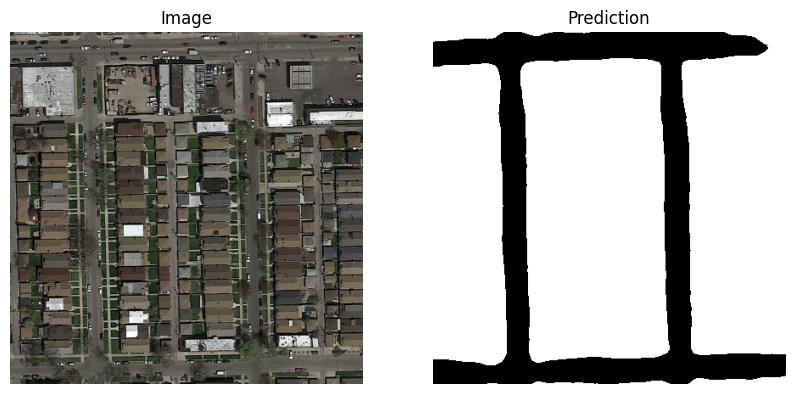

In [46]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Assuming test_loader is an instance of DataLoader using the Dataset class without masks
batch = next(iter(test_loader))
with torch.no_grad():
    test_model = test_model.to(DEVICE)
    test_model.eval()
    logits = test_model(batch[1].to(DEVICE))  # Ensure you move your inputs to the device where your model is
    pr_gts = logits.sigmoid()

for img_fp, pr_gt in zip(batch, pr_gts):
    img_fp = img_fp[0]
    print(img_fp)
    img = cv2.imread(img_fp)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (416, 416))

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
    plt.title("Image")
    plt.axis("off")

    # Convert the GPU tensor to CPU and then to a NumPy array before displaying
    plt.subplot(1, 2, 2)
    pr_gt_cpu = pr_gt.cpu().numpy().squeeze()  # Move to CPU and convert to NumPy
    pr_gt_cpu[pr_gt_cpu >= 0.6] = 1
    pr_gt_cpu[pr_gt_cpu < 0.6] = 0
    plt.imshow(pr_gt_cpu, cmap='gray')  # Show the prediction
    plt.title("Prediction")
    plt.axis("off")

    plt.show()


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]
 [0. 0. 0. ... 1. 1. 1.]]


(array([ 43715.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 129341.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

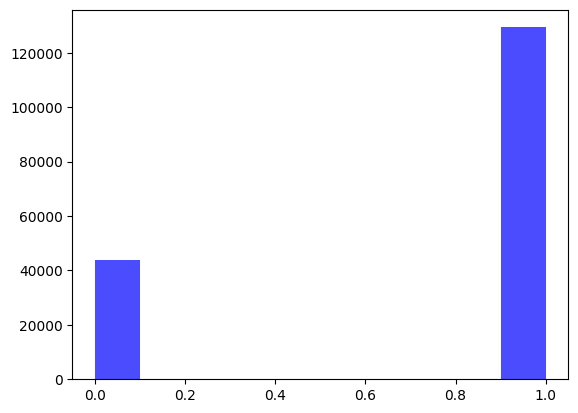

In [47]:
print(pr_gt_cpu)
plt.hist(pr_gt_cpu.flatten(), bins=10, color='blue', alpha=0.7)


./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_1/test_1.png


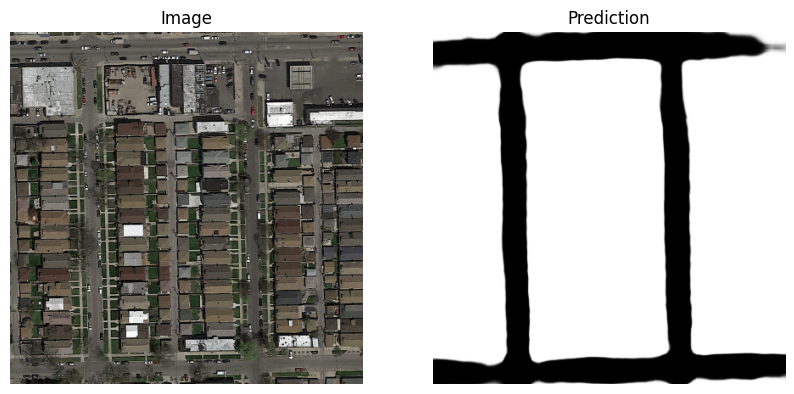

./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_2/test_2.png


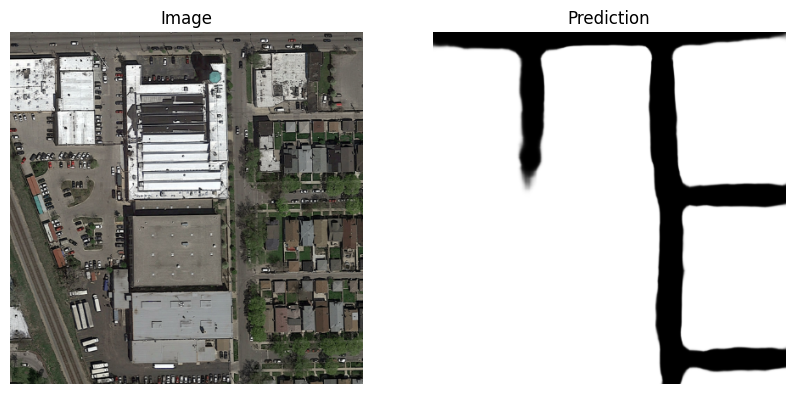

./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_3/test_3.png


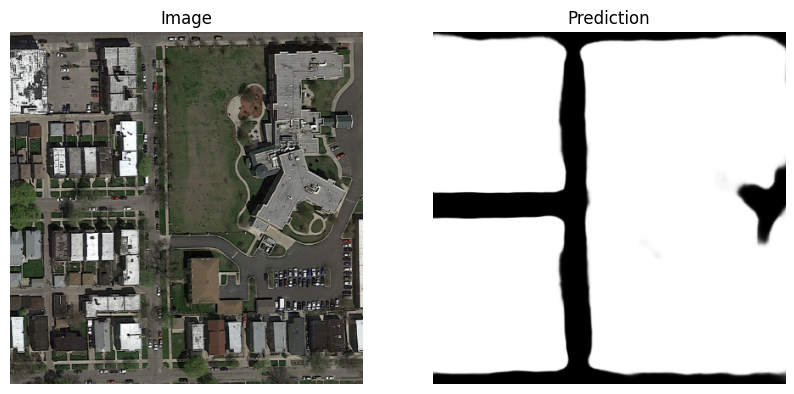

In [48]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import os

# Ensure the model is on the correct device and in evaluation mode
test_model = test_model.to(DEVICE)
test_model.eval()
img_nbr = 3
i = 0
# Iterate over all batches in the test_loader
for batch in test_loader:
    i += 1
    with torch.no_grad():
        # Move input to the device where the model is
        input_tensors = batch[1].to(DEVICE)
        logits = test_model(input_tensors)
        pr_gts = logits.sigmoid()

        # Since there are no ground truth masks, we only visualize the images and predictions
        for img_fp, pr_gt in zip(batch[0], pr_gts):  # batch[0] should contain the file paths
            print(img_fp)
            img = cv2.imread(img_fp)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (416, 416))

            # Get the prediction as a numpy array
            pr_gt_np = pr_gt.cpu().numpy().squeeze()

            plt.figure(figsize=(10, 5))

            plt.subplot(1, 2, 1)
            plt.imshow(img)  # No need to transpose axes since img is read with cv2 and already in HWC format
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 2, 2)
            plt.imshow(pr_gt_np, cmap='gray')  # Show the prediction
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
    if i == img_nbr:
      break


### .csv File

In [49]:
import os
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image, to_tensor
from PIL import Image

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_model = test_model.to(DEVICE)
foreground_threshold = 0.6  # Threshold for determining foreground vs background

# Parameters for saving images
output_folder = './submissions/submission_test_5/eval_imgs/'
os.makedirs(output_folder, exist_ok=True)

# Iterate over the DataLoader
for i, (path, image) in enumerate(test_loader):
    # print("Processing image:", i)
    path = path[0]
    with torch.no_grad():
        test_model.eval()
        # Move input to the device
        input_tensor = image.to(DEVICE)
        logits = test_model(input_tensor)
        # Apply sigmoid to get probabilities
        probabilities = torch.sigmoid(logits)
        # Squeeze to remove unnecessary dimensions
        probabilities = probabilities.squeeze(0).squeeze(0)
        # Apply threshold to the probabilities to binarize
        prediction_binarized = (probabilities < foreground_threshold).float()

        # Convert the binarized prediction to a PIL image
        prediction_pil = to_pil_image(prediction_binarized)

        # Resize the PIL image to 608x608
        prediction_pil_resized = prediction_pil.resize((608, 608), Image.NEAREST)

        # Save the image
        image_num = path.split('/')[-1].split('_')[-1].split('.')[0]
        image_num = int(image_num)
        filename = "test_eval_" + '%.3d' % image_num + '.png'
        prediction_pil_resized.save(os.path.join(output_folder, filename))
        # print(f"Saved {filename}")


./data/test_set_images/test_1/test_1.png
./data/test_set_images/test_2/test_2.png
./data/test_set_images/test_3/test_3.png
./data/test_set_images/test_4/test_4.png
./data/test_set_images/test_5/test_5.png
./data/test_set_images/test_6/test_6.png
./data/test_set_images/test_7/test_7.png
./data/test_set_images/test_8/test_8.png
./data/test_set_images/test_9/test_9.png
./data/test_set_images/test_10/test_10.png
./data/test_set_images/test_11/test_11.png
./data/test_set_images/test_12/test_12.png
./data/test_set_images/test_13/test_13.png
./data/test_set_images/test_14/test_14.png
./data/test_set_images/test_15/test_15.png
./data/test_set_images/test_16/test_16.png
./data/test_set_images/test_17/test_17.png
./data/test_set_images/test_18/test_18.png
./data/test_set_images/test_19/test_19.png
./data/test_set_images/test_20/test_20.png
./data/test_set_images/test_21/test_21.png
./data/test_set_images/test_22/test_22.png
./data/test_set_images/test_23/test_23.png
./data/test_set_images/test_2

In [50]:
SUBMISSION_PATH = "./submissions/submission_test_5/"
submission_filename = SUBMISSION_PATH + 'test_submission.csv'
image_filenames = []
for i in range(1, 51):
    # image_filename = 'training/groundtruth/satImage_' + '%.3d' % i + '.png'
    image_filename = SUBMISSION_PATH + 'eval_imgs/test_eval_' + '%.3d' % i + '.png'
    image_filenames.append(image_filename)
masks_to_submission(submission_filename, *image_filenames)


Streaming output truncated to the last 5000 lines.
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a zero
a ze